# Hands On Astropy Tutorial - Solutions to the exercises
**Tutors:** Axel Donath and Christoph Deil


This notebook contains the solutions to the exercises in [astropy_hands_on.ipynb](https://github.com/Asterics2020-Obelics/School2017/blob/master/astropy/astropy_hands_on.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 1. Units and Quantities

- (*easy*) How long does the light travel from the sun to the earth in minutes? How long does the light travel from the Galactic center (assume a distance of 8 kpc) in years? 


In [2]:
from astropy import constants as const
import astropy.units as u

# distance sun - earth
distance_sun = 1 * u.au

# speed of light
speed = const.c

# time
time_sun = distance_sun / speed
print("Light travels from sun to earth in {:.2f}".format(time_sun.to('min')))

# distance to GC
distance_gc = 8 * u.kpc

# time
time_gc = distance_gc / speed
print("Light travels from the GC to earth in {:.2f}".format(time_gc.to('yr')))

Light travels from sun to earth in 8.32 min
Light travels from the GC to earth in 26092.51 yr


- (*advanced*) Define a new unit called `"baro-meter"`, which is eqivalent to 25 cm and use it to measure the height of the empire state building (assume a height of 381 meters). Please read the [Astropy documentation on equivalencies](http://docs.astropy.org/en/stable/units/equivalencies.html#writing-new-equivalencies) for an example how to do this ( For other ways to measure the height of a building using a barometer see [barometer question on Wikipedia](https://en.wikipedia.org/wiki/Barometer_question)...)

In [3]:
import astropy.units as u

# define new unit baro-meter
bm = u.def_unit('baro-meter', 25 * u.cm)
u.add_enabled_units(bm)

# height of the empire state building
height = 381 * u.m

# convert to baro-meters
height_bm = height.to("baro-meter")
print("The height of the empire state building in baro-meters is {}".format(height_bm))

The height of the empire state building in baro-meters is 1524.0 baro-meter


- (*expert*) Find the frequency with the maximum photon rate of the black body spectrum $\mathcal{B}(\nu, T)$ with temperature $T=5000~\mathrm{K}$. For this you can use a numerical optimization routine such as [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).
As the frequency as well as the radiance can cover many orders of magnitude, the stability of the algorithm can be much improved by minimizing the (negative) logarithm of the radiance $-\log{\mathcal{B}}$ as well as minimizing with respect to the logarithm of the frequency by introducing the variable $x = \log{\nu}$. Finally compare the result against the analytical solution from [Wien's displacement law](https://en.wikipedia.org/wiki/Wien%27s_displacement_law). 

In [4]:
from scipy.optimize import minimize

# Copy over the definition from the tutorial notebook 
@u.quantity_input(frequency=u.hertz, temperature=u.K)
def blackbody(frequency, temperature): 
    pre_factor = 2 * (const.h * frequency ** 3) / const.c ** 2
    exponential_factor = 1. / (np.exp((const.h * frequency) / (const.k_B * temperature)) - 1)
    return pre_factor * exponential_factor


# Define the objective function that shall be minimized
# We introduce x = np.log(frequency) => frequency = np.exp(x)
# And convert the radiance to well defined units and take the negative logarithm
def objective_funtion(x):
    frequency = u.Quantity(np.exp(x) , unit="Hz", copy=False)
    radiance = blackbody(frequency=frequency, temperature=5000 * u.K)
    value = -np.log(radiance.to_value('Hz3 J s3 / m2'))
    return value
 
result = minimize(objective_funtion, x0=np.log(1E14), method='Nelder-Mead') 
frequency_max = np.exp(result['x']) * u.Hz

# Equation taken from https://en.wikipedia.org/wiki/Wien%27s_displacement_law#Alternate_Maxima
@u.quantity_input(temperature=u.K)
def wiens_displacement_law(temperature):
    return 0.058789e12 * u.Unit("Hz /K") * temperature 


frequency_max_wien = wiens_displacement_law(temperature=5000*u.K)

In [5]:
print("The numerical optimization gives: {[0]:.3e}".format(frequency_max))
print("Wien's displacement law gives   : {:.3e}".format(frequency_max_wien))

The numerical optimization gives: 2.939e+14 Hz
Wien's displacement law gives   : 2.939e+14 Hz


## 2. Coordinates

- (*easy*) Define the sky coordinate for your favorite object and find the distance to the crab nebula and Galactic center.

In [6]:
from astropy.coordinates import SkyCoord

# Coordinate of PKS2155-305
# coord_pks = SkyCoord.from_name('pks2155-304')
coord_pks = SkyCoord("21h58m52.7s", "-30d13m18s", frame="icrs")

# Coordinate of the Crab Nebula
# coord_crab = SkyCoord.from_name('crab')
coord_crab = SkyCoord(83.63 * u.deg,  22.01 * u.deg, frame='icrs')

separation_crab = coord_pks.separation(coord_crab)
print('The angular distance between PKS2155-204 and the Crab Nebula is {:.2f}'.format(separation_crab))

# Coordinate of the Galactic Center
coord_gc = SkyCoord(0, 0, unit='deg', frame='galactic')
separation_gc = coord_pks.separation(coord_gc)
print('The angular distance between PKS2155-204 and the Galactic Center is {:.2f}'.format(separation_gc))

The angular distance between PKS2155-204 and the Crab Nebula is 120.89 deg
The angular distance between PKS2155-204 and the Galactic Center is 54.33 deg


- (*expert*) Make a plot of the height above horizon vs.time for the crab position at the location of Annecy. Mark the the time range where it is visible. Would the crab be visible tonight?

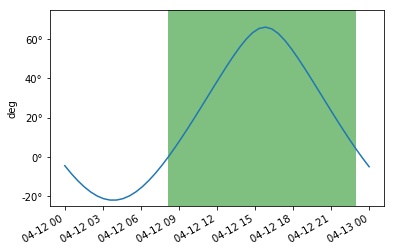

In [7]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time
import numpy as np
from astropy.visualization import quantity_support

# Define coordinate
coord_crab = SkyCoord(83.63 * u.deg,  22.01 * u.deg, frame='icrs')

# Set location
annecy = EarthLocation(lat=45.8058 * u.deg, lon=6.5726 * u.deg)

# Define array of times (30 minute intervals)
time_intervals = np.linspace(0 * u.day, 1 *u.day, 48)

time_start = Time('2019-04-12 00:00:00')
times = Time(time_start + time_intervals)

# Get AltAz coordinates
altaz = AltAz(obstime=times, location=annecy)
crab_altaz = coord_crab.transform_to(altaz)

# Get altitude over horizon
altitudes = crab_altaz.alt.to('deg')

# Get times when altitude > 0
above_horizon = altitudes > 0 * u.deg

with quantity_support():
    plt.plot_date(times.plot_date, altitudes, fmt='-')
    
    # orient date labels at a slant
    plt.gcf().autofmt_xdate() 
    
    alt_min, alt_max = -25 * u.deg, 75 * u.deg
    plt.fill_between(times.plot_date,
                     alt_min, alt_max,
                     where=above_horizon,
                     facecolor='green',
                     alpha=0.5)
    plt.ylim(alt_min, alt_max)

## 3. Tables

- (*easy*) Add columns with the `RA` and `DEC` coordinates of the objects to the example table.

In [8]:
# Get example table
from astropy.table import Table

table = Table()
table['Source_Name'] = ['Crab', 'Sag A*', 'Cas A']
table['GLON'] = [184.55754381, 0, 111.74169477] * u.deg
table['GLAT'] = [-5.78427369, 0, -2.13544151] * u.deg

# Create SkyCoord object holding all 3 sky coordinates
coords = SkyCoord(table['GLON'], table['GLAT'], frame='galactic')

# Add new columns
table['RA'] = coords.icrs.ra
table['DEC'] = coords.icrs.dec

table

Source_Name,GLON,GLAT,RA,DEC
,deg,deg,deg,deg
str6,float64,float64,float64,float64
Crab,184.55754381,-5.78427369,83.63320833052823,22.014472226225813
Sag A*,0.0,0.0,266.4049882865447,-28.936177761791473
Cas A,111.74169477,-2.13544151,350.8664167089621,58.81177779991024


- (*advanced *) Load the Fermi 2FHL catalog table (`'data/fermi_2fhl_catalog.fits'`) and find the brighest source (the brightness value is stored in the `'Flux50'` column). What is the common name of the source (column `'ASSOC'`)?
Find all sources within 10 deg from the position of this source.

In [9]:
# Read table
fermi_2fhl = Table.read('data/fermi_2fhl_catalog.fits', hdu=1)

# Sort by brightness
fermi_2fhl.sort('Flux50')

# With -1 we get the last element
print('The brightest source in the catalog is: {} \n'.format(fermi_2fhl[-1]['ASSOC']))



# Defie SkyCoord for all objects in the table
coords = SkyCoord(fermi_2fhl['GLON'], fermi_2fhl['GLAT'], frame='galactic')

# Get Crab position
coord_crab = coords[fermi_2fhl["ASSOC"] == "Crab"]


# Find rows where separation < 1 deg
separation = coord_crab.separation(coords)

# Print result
max_separation = 10 * u.deg
fermi_2fhl[separation < max_separation]

The brightest source in the catalog is: Crab 



Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Pos_err_68,Pos_err_95,TS,Spectral_Index,Unc_Spectral_Index,Intr_Spectral_Index_D11,Unc_Intr_Spectral_Index_D11,Intr_Spectral_Index_G12,Unc_Intr_Spectral_Index_G12,Flux50,Unc_Flux50,Energy_Flux50,Unc_Energy_Flux50,Flux50_171GeV,Unc_Flux50_171GeV [2],Sqrt_TS50_171GeV,Flux171_585GeV,Unc_Flux171_585GeV [2],Sqrt_TS171_585GeV,Flux585_2000GeV,Unc_Flux585_2000GeV [2],Sqrt_TS585_2000GeV,Npred,HEP_Energy,HEP_Prob,ROI,ASSOC,ASSOC_PROB_BAY,ASSOC_PROB_LR,CLASS,Redshift,NuPeak_obs,3FGL_Name,1FHL_Name,TeVCat_Name
,deg,deg,deg,deg,deg,deg,,,,,,,,ph / (cm2 s),ph / (cm2 s),erg / (cm2 s),erg / (cm2 s),ph / (cm2 s),ph / (cm2 s),,ph / (cm2 s),ph / (cm2 s),,ph / (cm2 s),ph / (cm2 s),,,GeV,,,,,,,,Hz,,,
bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes25,float32,float32,bytes8,float32,float32,bytes18,bytes18,bytes18
2FHL J0534.1+2753,83.525,27.886,179.544,-2.704,0.049,0.079,29.1,3.18,1.10,nan,nan,nan,nan,1.6400e-11,8.0200e-12,2.4000e-12,1.4400e-12,1.2975e-11,-5.3815e-12 .. 7.3262e-12,5.44,5.1763e-16,nan .. 6.2549e-12,0.00,1.8205e-16,nan .. 5.8903e-12,0.00,4.90,135.43,0.99,17,S147,nan,0.8939,snr,0.00000,nan,3FGL J0540.3+2756e,,
2FHL J0515.5+1530,78.888,15.503,187.622,-13.094,0.065,0.104,42.0,6.41,2.27,nan,nan,nan,nan,2.4200e-11,9.7300e-12,2.3800e-12,9.8500e-13,6.1487e-12,-2.1737e-12 .. 2.8043e-12,6.49,4.5839e-13,nan .. 7.6937e-12,0.61,1.0190e-17,nan .. 6.7986e-12,0.00,6.80,68.77,0.99,17,NVSS J051547+152716,0.9940,nan,bll,nan,6.6681e+13,3FGL J0515.8+1526,1FHL J0515.9+1528,
2FHL J0521.7+2112,80.438,21.209,183.607,-8.714,0.031,0.050,562.6,2.92,0.27,2.78,0.28,2.76,0.28,2.0400e-10,2.7500e-11,3.2900e-11,5.8600e-12,1.6515e-10,-2.1797e-11 .. 2.3864e-11,23.20,8.3150e-12,-4.2235e-12 .. 6.1628e-12,5.35,7.5567e-17,nan .. 5.9877e-12,0.00,58.90,316.79,0.86,17,TXS 0518+211,1.0000,0.9867,bll,0.10800,2.1627e+14,3FGL J0521.7+2113,1FHL J0521.7+2113,TeV J0521+211
2FHL J0617.2+2234e,94.310,22.580,189.048,3.033,0.000,0.000,398.6,2.66,0.21,nan,nan,nan,nan,2.7000e-10,3.2100e-11,4.9700e-11,8.3900e-12,2.1090e-10,-2.5807e-11 .. 2.7968e-11,18.80,2.4934e-11,-8.2973e-12 .. 1.0530e-11,6.62,7.1373e-12,-3.9838e-12 .. 6.3763e-12,3.70,78.20,699.50,0.98,23,IC 443,nan,nan,snr,nan,nan,3FGL J0617.2+2234e,1FHL J0617.2+2234e,TeV J0616+225
2FHL J0534.5+2201,83.634,22.021,184.552,-5.780,0.030,0.049,5149.7,2.13,0.07,nan,nan,nan,nan,1.3100e-09,6.8300e-11,3.5200e-10,2.9000e-11,9.9407e-10,-5.7595e-11 .. 5.9473e-11,63.58,2.4388e-10,-2.8254e-11 .. 3.0435e-11,33.18,5.2754e-11,-1.3340e-11 .. 1.6048e-11,14.46,377.70,1463.30,1.00,19,Crab,0.9983,0.9969,pwn,nan,nan,3FGL J0534.5+2201i,1FHL J0534.5+2201,TeV J0534+220p


- (*expert*) Make an allsky plot (using an 'Aitoff' projection) of all the sources in the Fermi 2FHL catalog grouped by source class (i.e. choose a different marker color for every source class). The class of the sources is stored in the `'CLASS'` column. There are a few possible ways to identify the groups of source class. One of them is to use [Table.group_by()](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table.group_by) followed by a loop over the groups (check Astropy documentation!) another way is to use a regular Python `set` to idenfity the unique entries in the `'CLASS'` column and loop over those. You can use `plt.subplot(projection='aitoff')` to instanciate a matplotlib axes with `'Aitoff'` projection. Note that the `'Aitoff'` projection requires angular positions measured in radians.

In [10]:
source_classes = set(fermi_2fhl['CLASS'])

print('Source classes: {}'.format(source_classes))

Source classes: {'bll', 'sfr', 'bin', 'bcu I', 'unk', 'rdg/bll', 'gal', 'galclu', 'bll-g', 'fsrq', 'bcu II', 'spp', 'rdg', 'psr', 'agn', 'snr', 'pwn', 'hmb', 'bcu III'}


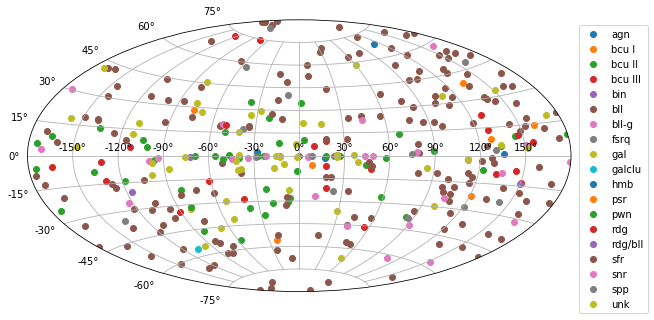

In [11]:
from astropy.coordinates import Angle

plt.figure(figsize=(12, 5))
ax = plt.subplot(projection='aitoff')

glon = Angle(fermi_2fhl['GLON'].quantity)
glon = glon.wrap_at('180d')

glat = Angle(fermi_2fhl['GLAT'].quantity)

with quantity_support():
    for source_class in sorted(source_classes):
        selection = fermi_2fhl['CLASS'] == source_class
        ax.scatter(glon[selection].rad, glat[selection].rad, label=source_class)
    ax.grid()
    plt.legend(bbox_to_anchor=(1.15, 1), loc=1)

## 4. FITS Images and WCS

- (*easy*) Read in the data from the other energy bands (`'data/casa_1.5-3.0keV.fits.gz'` and `'data/casa_4.0-6.0keV.fits.gz'`) as well, sum up all the data from the three energy bands. Plot the summed data using [plt.imshow()](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.imshow.html) again.

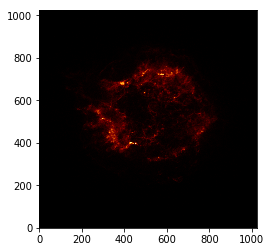

In [12]:
from astropy.io import fits

filenames = ['data/casa_0.5-1.5keV.fits.gz', 'data/casa_1.5-3.0keV.fits.gz',
             'data/casa_4.0-6.0keV.fits.gz']

data_list = []

for filename in filenames:
    image_hdu = fits.open(filename)['PRIMARY']
    data_list.append(image_hdu.data)
    
data_summed = np.sum(data_list, axis=0)
plt.imshow(data_summed, origin='lower', cmap='afmhot')

- (*advanced*) Cutout the central region of the image using [astropy.nddata.Cutout2D](http://docs.astropy.org/en/stable/api/astropy.nddata.Cutout2D.html) (size of 0.05 deg x 0.05 deg around the position of `'Cas A'`). Find the sky position of the brightest pixel in the cutout data. For this [np.argmax()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) and [np.unravel_index()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unravel_index.html) might be helpful. Make sure you use the updated `.data` and `.wcs` attributes of the `Cutout2D` object to achieve the latter.

In [13]:
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

image_hdu = fits.open('data/casa_0.5-1.5keV.fits.gz')['PRIMARY']
wcs = WCS(image_hdu.header) 
image_data = image_hdu.data

pos_casa = SkyCoord('23h23m27.94s', '+58d48m42.4s', frame='icrs')

data_cutout = Cutout2D(image_data, position=pos_casa,
                       wcs=wcs, size=0.05 * u.deg)

# Find index of maximum value (this will return the
# index on the flattened array)
idx_flat = data_cutout.data.argmax()

# Transform back to the original shape
idx = np.unravel_index(idx_flat, data_cutout.data.shape)

# Transform to SkyCoord
pos = SkyCoord.from_pixel(*idx, wcs=data_cutout.wcs)
print("The position of the brightest pixel in the image is: {}".format(pos))

The position of the brightest pixel in the image is: <SkyCoord (ICRS): (ra, dec) in deg
    (350.86657467, 58.81187392)>


- (*very hard*) Calculate a radial profile of the image data to estimate the size of the shell of the supernova remnant. For this sum up all the data within a set of rings (specified  by `radii_min` and `radii_max`, choose a total minimum radius of `0 arcmin` and total maximum radius of `5 arcmin`) around the center position of *Cas A*. You can use [np.indices()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.indices.html) to get arrays of x and y pixel positions. Make sure you use clever numpy broadcasting to avoid a Python loop over the `radii_min` and `radii_max` arrays (**hint**: [ndarray.reshape(-1, ...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html#numpy.reshape) might be useful to expand the data and radius array to the third dimension).

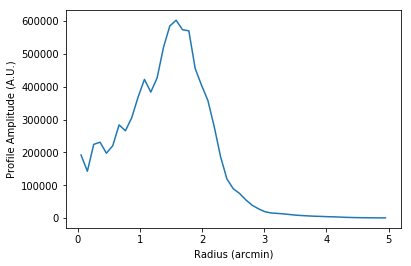

In [14]:
from astropy.wcs import WCS
from astropy.io import fits 
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
    
# open image
image_hdu = fits.open('data/casa_1.5-3.0keV.fits.gz')['PRIMARY']
wcs = WCS(image_hdu.header)
image_data = image_hdu.data

# define position and integration radius
pos_casa = SkyCoord('23h23m27.94s', '+58d48m42.4s', frame='icrs')

# create an array of sky positions for each pixel
yp, xp = np.indices(image_data.shape)
sky_positions = SkyCoord.from_pixel(xp=xp, yp=yp, wcs=wcs)

# calculate separation image
separation = pos_casa.separation(sky_positions)

# initialize radius arrays
radii = np.linspace(0, 5, 50).reshape(-1, 1, 1) * u.arcmin
radii_min, radii_max = radii[:-1], radii[1:]

# mask out the annulus regions
mask = (separation > radii_min) & (separation < radii_max)

data_masked = mask * image_data.reshape(-1, 1024, 1024)
data_summed = data_masked.sum(axis=-1).sum(axis=-1)

radius_center = (radii_min[:, 0, 0] + radii_max[:, 0, 0]) / 2.

r_dr = radius_center * (radii_max - radii_min).squeeze()

with quantity_support():
    plt.plot(radius_center, data_summed / (2 * np.pi * r_dr))
    plt.xlabel('Radius (arcmin)')
    plt.ylabel('Profile Amplitude (A.U.)')

**Note:** Even if we avoided the Python loop by expanding the Numpy data array in the third dimension, this is still not
the most efficient implementation to measure radial profiles on images. Better solutions are based on counting pixels by indices. E.g. look at the implementation proposed here: https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile/21242776#2124277e.

## 5. Plotting of sky images (optional)

- (*easy*) Make a combined plot of the Chandra data for all energy bands side by side (one row, three columns)
and put the energy information in the title of the subplot. You can use e.g. `plt.sublots()`.  

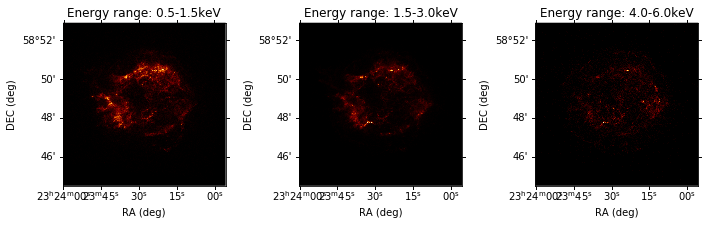

In [15]:
from astropy.io import fits
from astropy.wcs import WCS

# We define a figure size, that has an aspect ratio to accomodate three plots side by side
fig = plt.figure(figsize=(12, 3))
filenames = ['data/casa_0.5-1.5keV.fits.gz', 'data/casa_1.5-3.0keV.fits.gz', 'data/casa_4.0-6.0keV.fits.gz']

# For convenience we use a Python loop here, but the same can be achieved
# by copy and pasting the code for one energy band
for idx, filename in enumerate(filenames):
    image_hdu = fits.open(filename)['PRIMARY']
    wcs = WCS(image_hdu.header)
    ax = plt.subplot(1, 3, idx + 1, projection=wcs)
    ax.imshow(image_hdu.data, origin='lower', cmap='afmhot')
    
    # We extract the energy range from the filename, by setting it "by hand" is also fine
    energy_range = filename[10:20]
    ax.set_title('Energy range: {}'.format(energy_range))
    
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('DEC (deg)')
    

- (*advanced*) Make a combined RGB image of the Chandra data in different energy bands. Therefore you have to
renormalize the data per energy band to the maximum value of respective energy band and combine the data into a 3d array with a shape that is recognised by `plt.imshow()` (check the matplotlib documentation!).

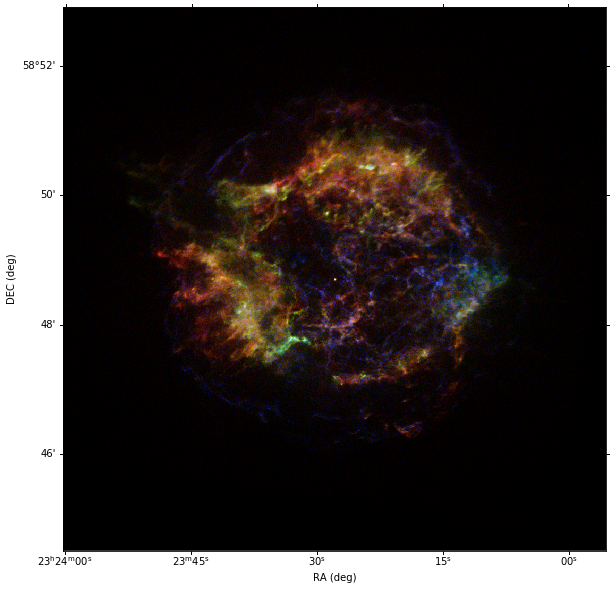

In [16]:
from astropy.visualization import AsinhStretch

# use asinh stretching to brighten up the image
stretch = AsinhStretch(0.1)

data_rgb = []

for filename in filenames:
    image_hdu = fits.open(filename)['PRIMARY']
    data = image_hdu.data
    data /= data.max()
    data = stretch(data)
    data_rgb.append(data)

data_rgb_stacked = np.stack(data_rgb, axis=2)

plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
ax.imshow(data_rgb_stacked, origin='lower')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

## Acknowledgements
![](asterics_log.png)

This tutorial was supported by the H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).